In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define helper functions and preprocessing steps

In [2]:
seed = 10
target = 'SalePrice'

def read_data(test_set=False):
    '''
    Read data from CSV
    
    Parameters
        test_set (bool): read only test set
    Returns
        X (n x m dataframe), y (n x 2 dataframe) <- returned only for train set
    '''
    if test_set:
        return pd.read_csv('test.csv')
        
    data = pd.read_csv('train.csv')

    return data.drop(columns=[target]), data[['Id', target]]

def null_cols(d):
    '''
    Find columns that have at least one null value
    
    Parametrs
        d (dataframe): dataframe with multiple columns
    Returns
        num_cols (series): column names and their percentage of
            observations with NaN for the column
    '''
    cols = d.columns[d.isnull().any()].to_numpy()

    return np.round(np.sum(d[cols].isnull()) / len(d), 2).sort_values()

def plot_against_target(X, y, col):
    '''
    Plot X[col] against y['SalePrice']

    Parameters
        X (dataframe): containing `col`
        y (dataframe): container `SalePrice`
    '''
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(X[col].fillna('None'), y[target] / 1000)
    ax.set_title(f'{col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

def preprocess(d):
    '''
    Preprocess data by dropping unimportant columns, handling NaN values, merging
    categories and encoding categorical variables
    Parameters
        X (dataframe)
    Returns
        X (dataframe) with a lot more columns than input
    '''
    cols_to_drop = ['Id', 'PoolQC', 'MiscFeature', 'MiscVal', 'MoSold', 'BsmtFinSF2', 'Utilities']
    
    d_ = d.copy()
    d_ = d_.drop(columns=cols_to_drop)

    null_num_cols = null_cols(d_.select_dtypes('number')).index
    d_[null_num_cols] = d_[null_num_cols].fillna(0.0)
    
    null_cat_cols = null_cols(d_.select_dtypes('object')).index
    d_[null_cat_cols] = d_[null_cat_cols].fillna('None')

    combined_zoning = 'RL-RM-C (all)'
    d_['MSZoning'] = d_['MSZoning'].replace('RL', combined_zoning)
    d_['MSZoning'] = d_['MSZoning'].replace('RM', combined_zoning)
    d_['MSZoning'] = d_['MSZoning'].replace('C (all)', combined_zoning)

    cat_cols = d_.select_dtypes('object').columns
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe.fit(d_[cat_cols])
    d_ = d_.join(pd.DataFrame(ohe.transform(d_[cat_cols])))
    d_ = d_.drop(columns=cat_cols)

    return d_

def preprocess_y(y):
    '''
    Converts the target values into log scale
    Parameters
        y (dataframe): containing SalePrice column
    Returns
        y (series)
    '''
    return np.log(y[target])

# Read data into and extract the dependent/independent variables into dataframes

In [3]:
X, y = read_data()

# Preprocess X and y

In [4]:
X = preprocess(X)
y = preprocess_y(y)
X = X.to_numpy()
y = y.to_numpy()

# Split the dataset into train/test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)

# Standardize the input and fit a Lasso model

In [6]:
model = make_pipeline(StandardScaler(),
                      Lasso(alpha=0.005, max_iter=10000, random_state=seed))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.005, max_iter=10000, random_state=10))])

# Make predictions on the test set

Train RMSE: 0.012
Test RMSE: 0.015
Test accuracy: 0.921


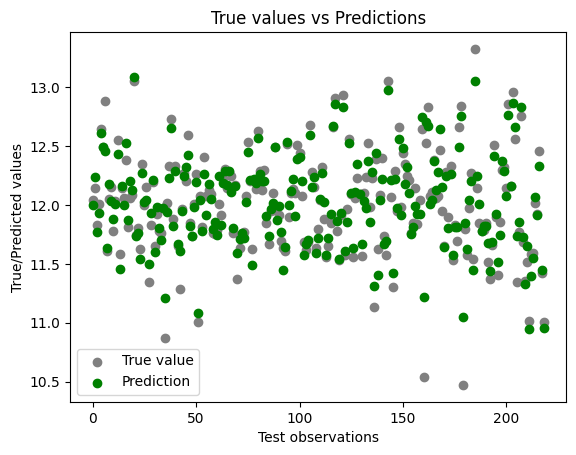

In [7]:
y_pred = model.predict(X_test)
train_y_pred = model.predict(X_train)
print(f'Train RMSE: {np.round(mean_squared_error(y_train, train_y_pred), 3)}')
print(f'Test RMSE: {np.round(mean_squared_error(y_test, y_pred), 3)}')
print(f'Test accuracy: {np.round(model.score(X_test, y_test), 3)}')
plt.scatter(np.arange(len(X_test)), y_test, c='grey', label='True value')
plt.scatter(np.arange(len(X_test)), y_pred, c='green', label='Prediction')
plt.xlabel('Test observations')
plt.ylabel('True/Predicted values')
plt.title('True values vs Predictions')
plt.legend()
plt.show()